In [1]:
import numpy as np 
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt

import ray

from tools_ryu import mytool
from multi_run_v3.data_pp import DataPreprocess
from multi_run_v3.momentum import make_group_mask
from multi_run_v3.momentum_strategy import *
from multi_run_v2.initialize_v2 import make_market_index

2023-08-15 17:11:05,047	INFO worker.py:1625 -- Started a local Ray instance.


In [2]:
data = pd.read_pickle("Data/cmktcap_data_final.pickle")

days_lst = ["MON","TUE","WED","THU","FRI","SAT","SUN"]

In [3]:
data_pp = DataPreprocess()
data_pp.initialize(data=data)
data_pp.make_mask(mktcap_thresh=1_000_000,
                  vol_thresh=1_000_000,
                  ma=True)

In [4]:
mkt = make_market_index(data_pp.price_df,
                        data_pp.mktcap_df,
                        data_pp.vol_df,
                        1_000_000,
                        1_000_000,
                        True)

In [5]:
# Ray Data 생성
ray_price = ray.put(data_pp.price_df)
ray_mktcap = ray.put(data_pp.mktcap_df)
ray_vol = ray.put(data_pp.vol_df)
ray_daily_rtn = ray.put(data_pp.daily_rtn_df)
ray_weekly_rtn = ray.put(data_pp.weekly_rtn_df)
ray_mask = ray.put(data_pp.mask)

In [6]:
# Terra Luna 제거

#price_pp = cmkt_data["price"].drop("4172", axis=1)
#mktcap_pp = cmkt_data["mktcap"].drop("4172", axis=1)
#vol_pp = cmkt_data["vol"].drop("4172", axis=1)
#ray_price = ray.put(price_pp)
#ray_mktcap = ray.put(mktcap_pp)
#ray_vol = ray.put(vol_pp)

### Value Weighted, Marketcap Capped 

In [7]:
momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       margin ='cross',
                                                                       leverage_ratio=2
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [8]:
momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       margin ='isolate',
                                                                       leverage_ratio=2
                                                                       ) 
              for day in days_lst]

momentum_capped_result2 = ray.get(momentum_capped_future)

In [9]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [10]:
momentum_result_dict_c2 = {"MON":momentum_capped_result2[0],
                          "TUE":momentum_capped_result2[1],
                          "WED":momentum_capped_result2[2],
                          "THU":momentum_capped_result2[3],
                          "FRI":momentum_capped_result2[4],
                          "SAT":momentum_capped_result2[5],
                          "SUN":momentum_capped_result2[6]}

In [11]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]

    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [12]:
final_c2 = {}

for day in days_lst:
    df_day = momentum_result_dict_c2[day]

    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c2[day] = concat_df

fin_c2 = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c2 = pd.concat([df[pf] for key, df in final_c2.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c2.index[0] - pd.Timedelta(days=1)
    concat_series_c2[start_idx] = 7
    fin_c2[pf] = concat_series_c2.sort_index().pct_change().fillna(0)

In [13]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

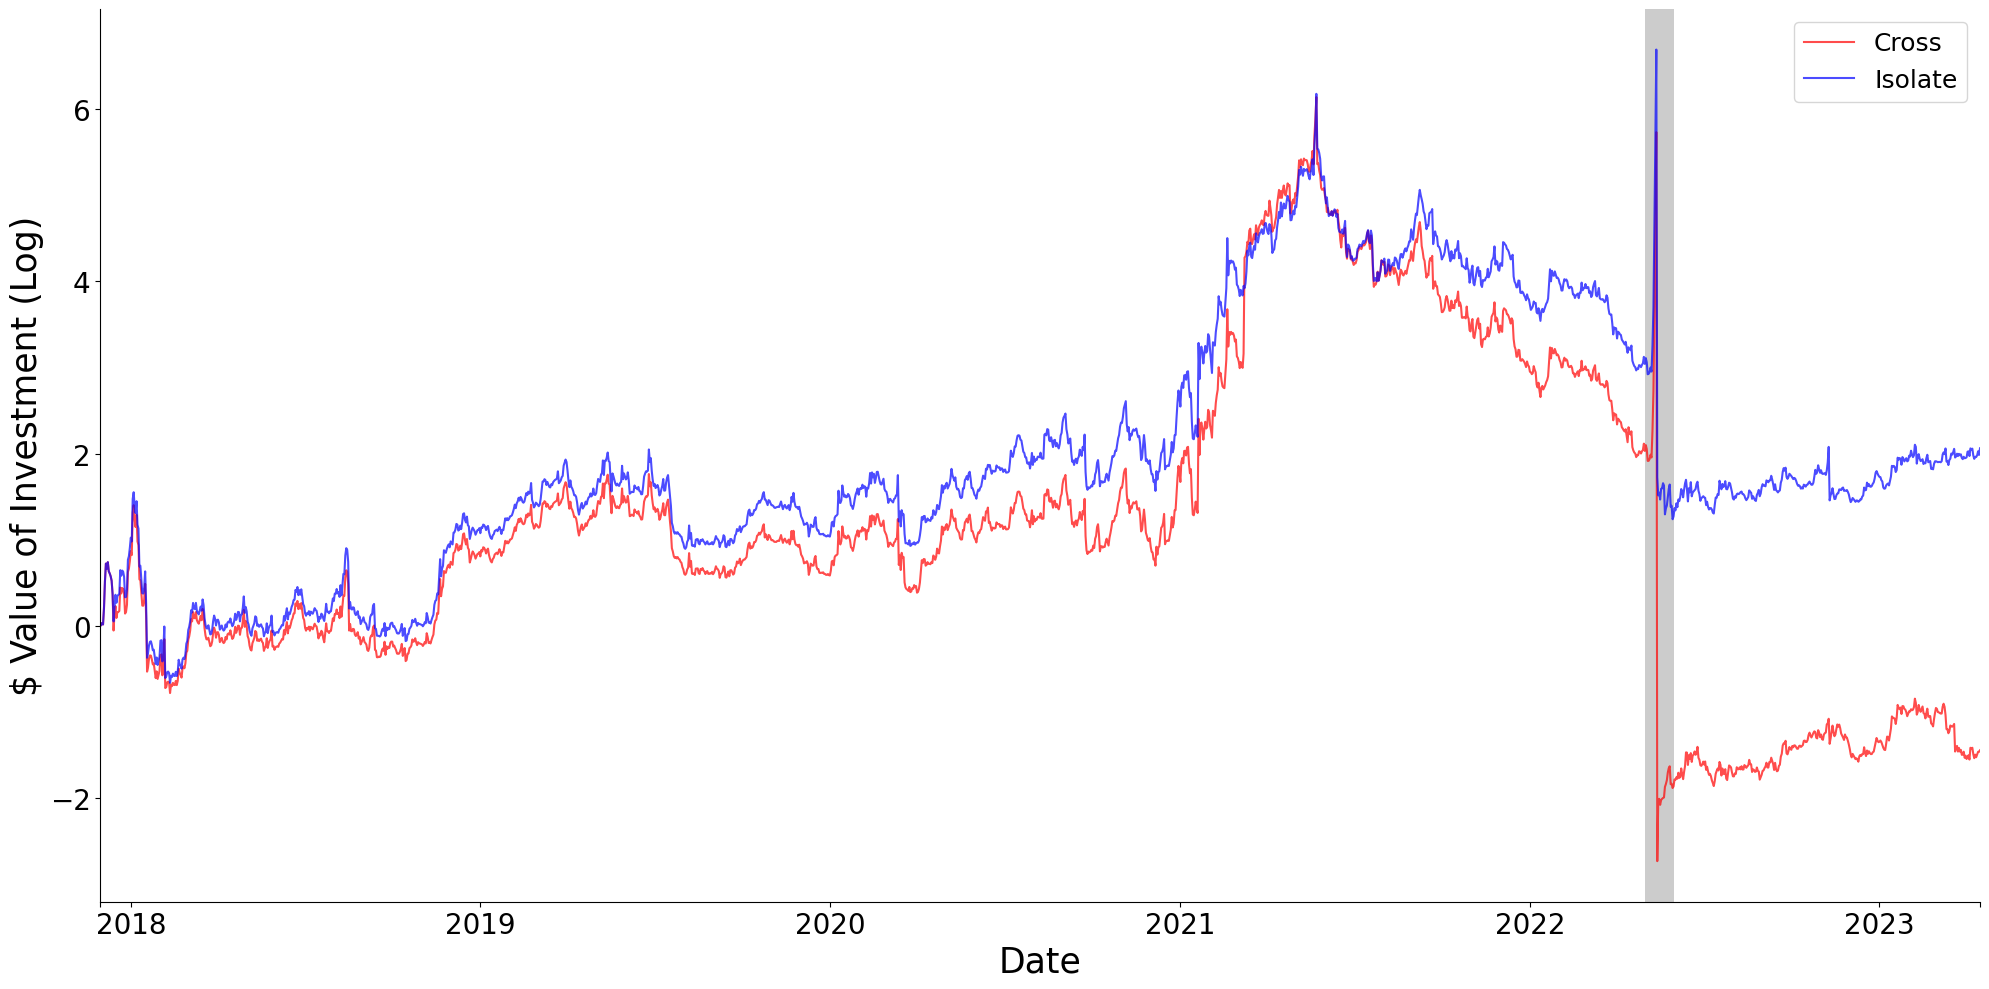

In [14]:
import matplotlib.dates as mdates

np.log((fin_c["LS"] + 1).cumprod()).plot(figsize=(20,10),c="r", alpha=0.7, fontsize=20)
np.log((fin_c2["LS"] + 1).cumprod()).plot(figsize=(20,10),c="b", alpha=0.7)


plt.legend(['Cross', "Isolate"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

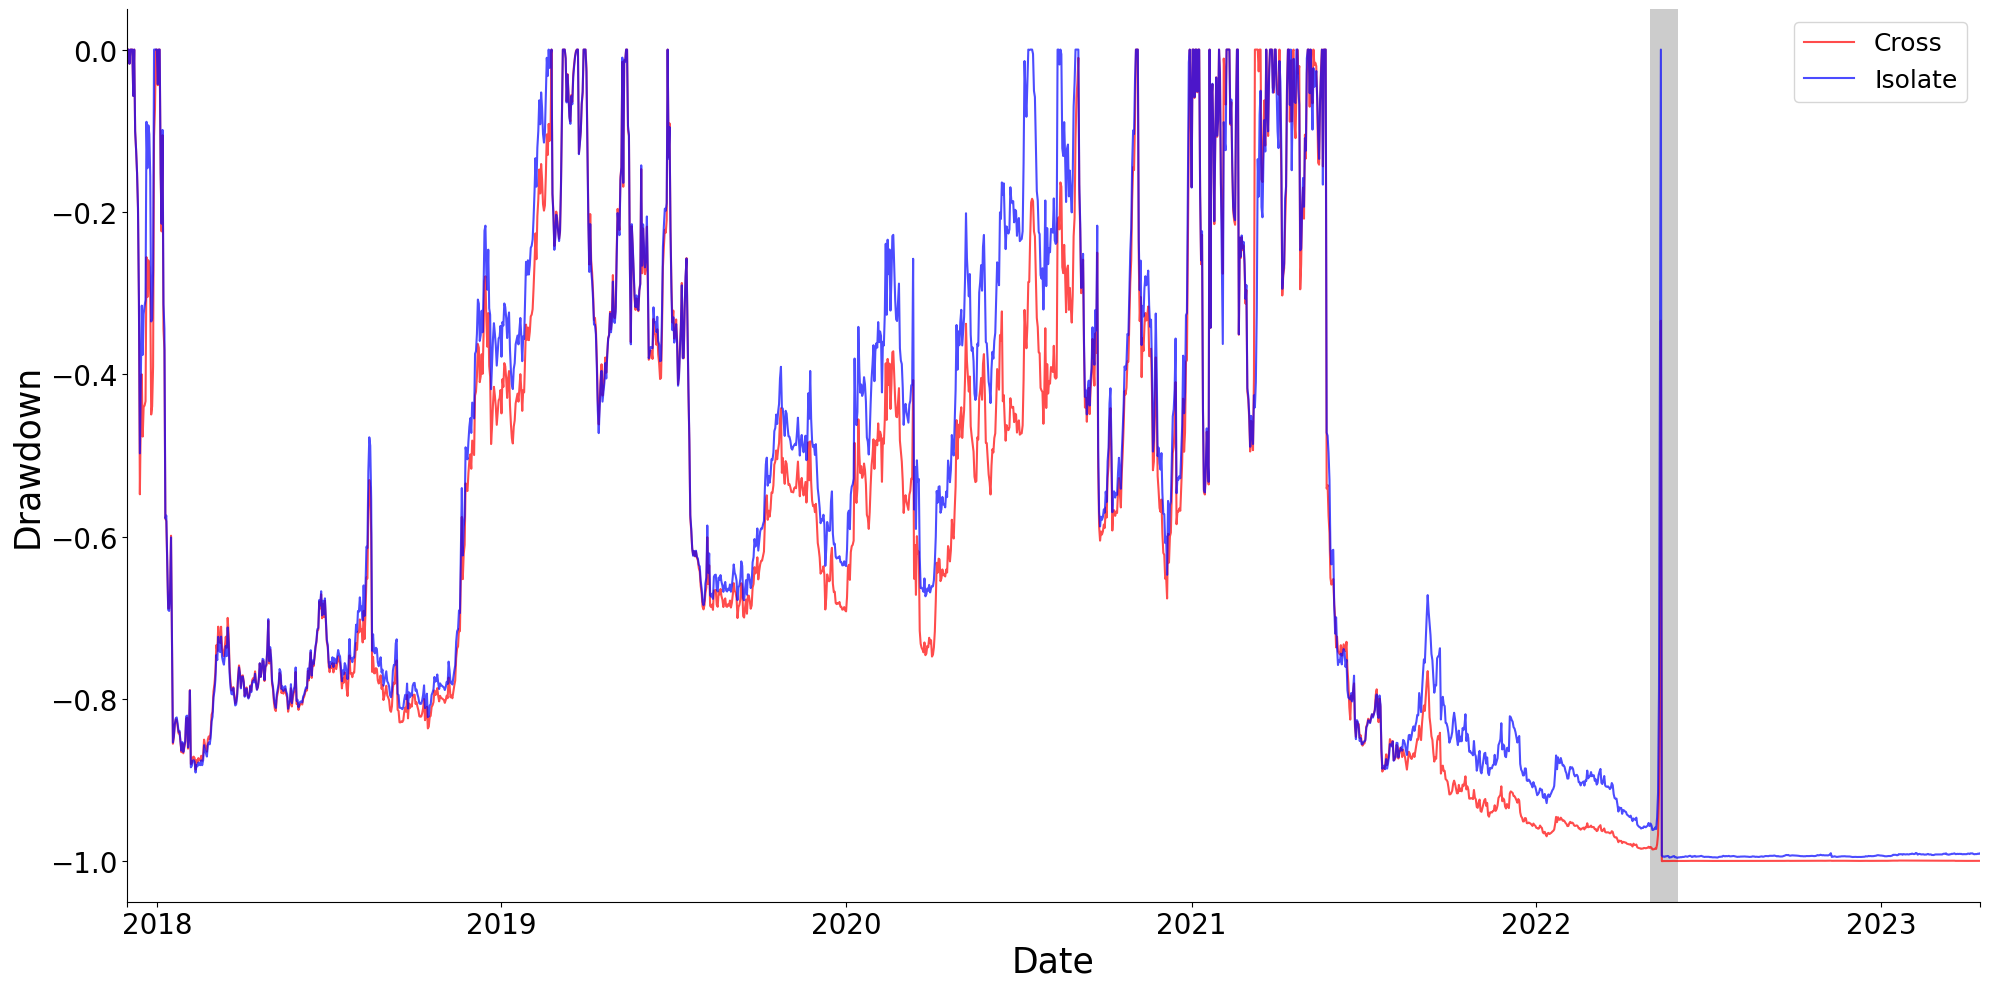

In [15]:
h_l = (fin_c["LS"] + 1).cumprod()
h_l2 = (fin_c2["LS"] + 1).cumprod()


h_l_peak = h_l.cummax()
h_l2_peak = h_l2.cummax()


h_l_dd = (h_l - h_l_peak) / h_l_peak
h_l2_dd = (h_l2 - h_l2_peak) / h_l2_peak

pd.concat([h_l_dd, h_l2_dd, h_l_dd], axis=1,
          keys=["Cross","Isolate"]).plot(figsize=(20,10), 
                                          color=["red","blue"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["Cross", "Isolate"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [16]:
mytool.print_statistics(pd.concat([fin_c["LS"], fin_c2["LS"]], axis=1, keys=["Cross", "Isolate"]))

,Cross,Isolate
Mean,3.282780,3.057180
STD,2.497652,2.293792
CAGR,-0.236700,0.465000
MDD,1.000000,0.996000
Sharpe,1.314346,1.332806


In [17]:
mytool.print_statistics(fin_c)

,Long_Q1,Long_Q2,Long_Q3,Long_Q4,Long_Q5,LS
Mean,-0.462410,0.009100,0.416940,0.656000,0.717380,3.282780
STD,0.990203,0.917889,0.863856,0.864337,0.951884,2.497652
CAGR,-0.620400,-0.346200,0.035200,0.311000,0.300500,-0.236700
MDD,0.998000,0.975000,0.935000,0.913000,0.941000,1.000000
Sharpe,-0.466985,0.009914,0.482650,0.758963,0.753642,1.314346


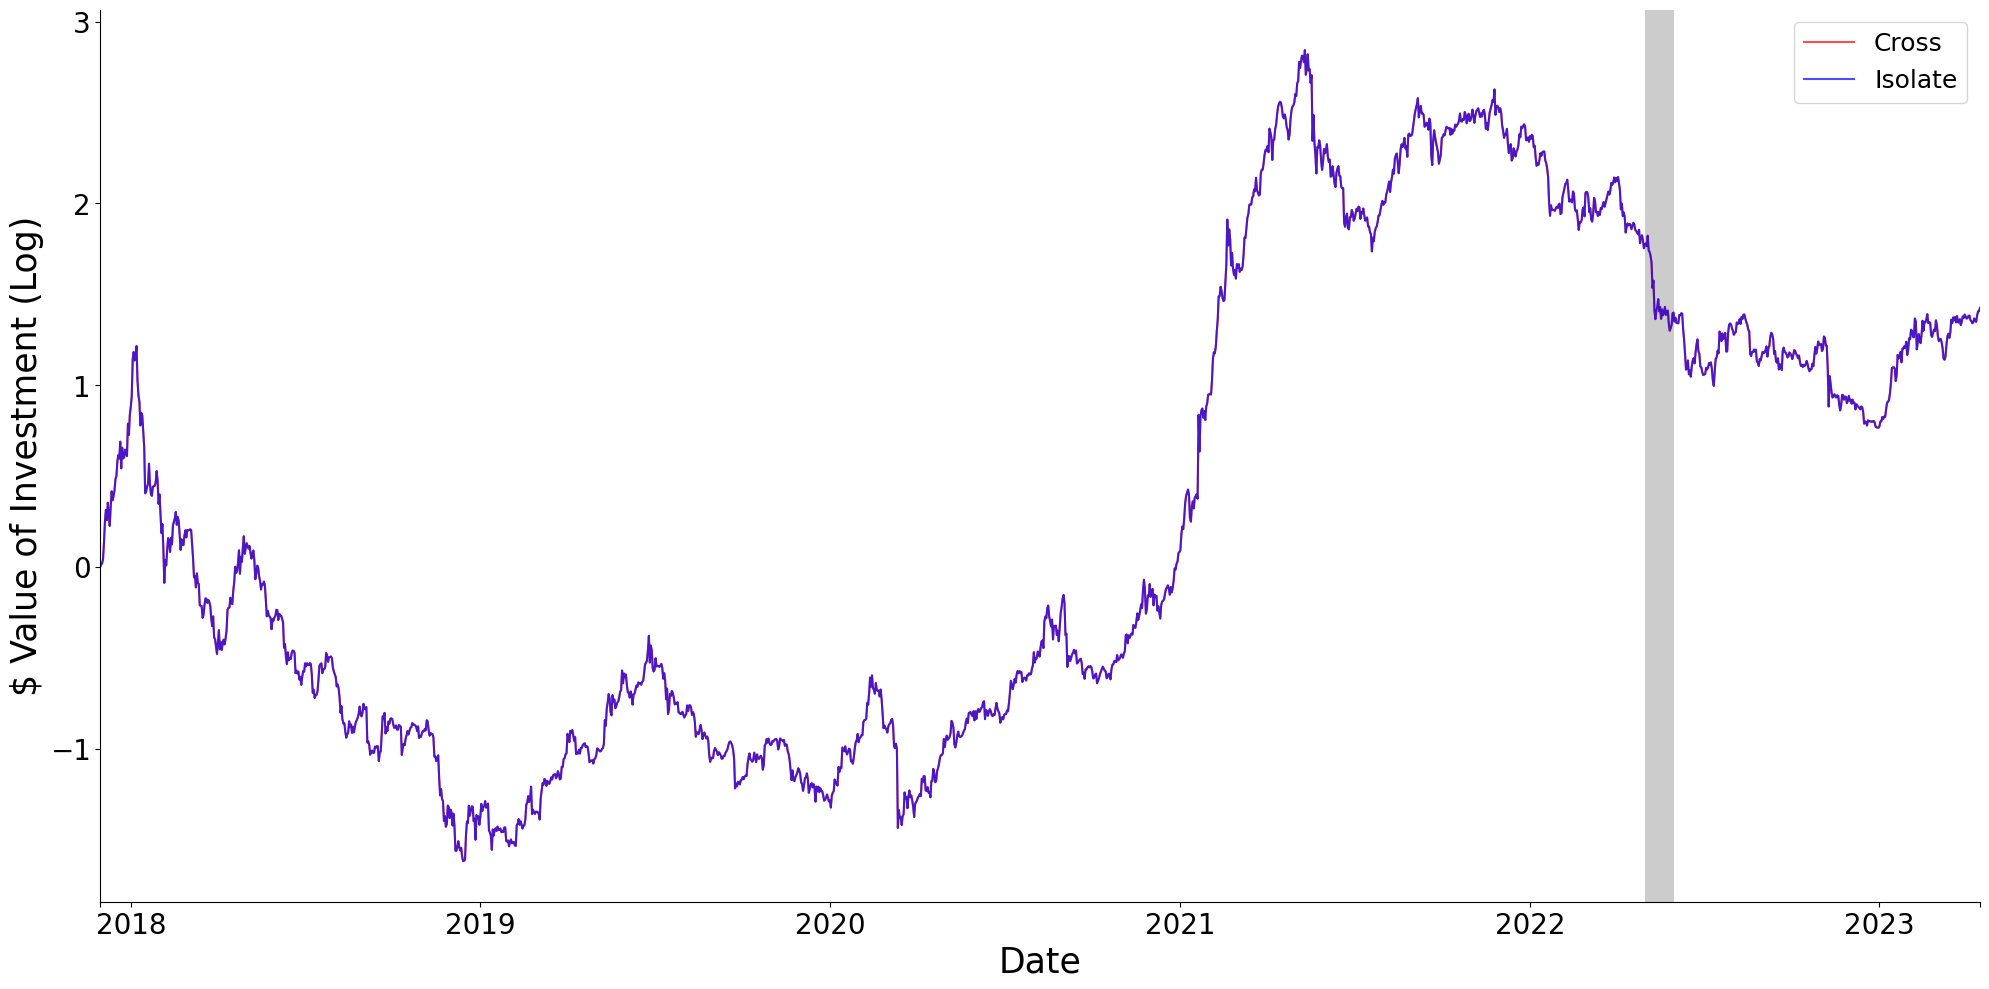

In [18]:
np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10),c="r", alpha=0.7, fontsize=20)
np.log((fin_c2["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10),c="b", alpha=0.7)


plt.legend(['Cross', "Isolate"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

Volume_weighted_capped

In [ ]:
momentum_capped_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       margin='cross'# 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_capped_future = [weekly_momentum_volume_weighted.remote(price_df=ray_price,
                                                                       mktcap_df=ray_mktcap,
                                                                       vol_df = ray_vol,
                                                                       daily_rtn_df = ray_daily_rtn,
                                                                       weekly_rtn_df = ray_weekly_rtn,
                                                                       mask_df = ray_mask,
                                                                       fee_rate = 0.0015,
                                                                       n_group=5,
                                                                       day_of_week=day,
                                                                       margin='isolate'# 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result2 = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

momentum_result_dict_c2 = {"MON":momentum_capped_result2[0],
                          "TUE":momentum_capped_result2[1],
                          "WED":momentum_capped_result2[2],
                          "THU":momentum_capped_result2[3],
                          "FRI":momentum_capped_result2[4],
                          "SAT":momentum_capped_result2[5],
                          "SUN":momentum_capped_result2[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]

    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
final_c2 = {}

for day in days_lst:
    df_day = momentum_result_dict_c2[day]

    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c2[day] = concat_df

fin_c2 = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS"]:
    concat_series_c2 = pd.concat([df[pf] for key, df in final_c2.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c2.index[0] - pd.Timedelta(days=1)
    concat_series_c2[start_idx] = 7
    fin_c2[pf] = concat_series_c2.sort_index().pct_change().fillna(0)

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["LS"] + 1).cumprod()).plot(figsize=(20,10),c="r", alpha=0.7, fontsize=20)
np.log((fin_c2["LS"] + 1).cumprod()).plot(figsize=(20,10),c="b", alpha=0.7)


plt.legend(['Cross', "Isolate"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment (Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
h_l = (fin_c["LS"] + 1).cumprod()
h_l2 = (fin_c2["LS"] + 1).cumprod()


h_l_peak = h_l.cummax()
h_l2_peak = h_l2.cummax()


h_l_dd = (h_l - h_l_peak) / h_l_peak
h_l2_dd = (h_l2 - h_l2_peak) / h_l2_peak

pd.concat([h_l_dd, h_l2_dd, h_l_dd], axis=1,
          keys=["Cross","Isolate"]).plot(figsize=(20,10), 
                                          color=["red","blue"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["Cross", "Isolate"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
mytool.print_statistics(pd.concat([fin_c["LS"], fin_c2["LS"]], axis=1, keys=["Cross", "Isolate"]))

No cap

In [ ]:
momentum_cmkt = {}

momentum_future = [weekly_momentum_value_weighted.remote(price_df=ray_price,
                                                                mktcap_df=ray_mktcap,
                                                                daily_rtn_df = ray_daily_rtn,
                                                                weekly_rtn_df = ray_weekly_rtn,
                                                                mask_df = ray_mask,
                                                                fee_rate = 0.0015,
                                                                n_group=5,
                                                                day_of_week=day,
                                                                ) 
              for day in days_lst]

momentum_result = ray.get(momentum_future)

In [ ]:
momentum_result_dict = {"MON":momentum_result[0],
                        "TUE":momentum_result[1],
                        "WED":momentum_result[2],
                        "THU":momentum_result[3],
                        "FRI":momentum_result[4],
                        "SAT":momentum_result[5],
                        "SUN":momentum_result[6]}

In [ ]:
final = {}

for day in days_lst:
    df_day = momentum_result_dict[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final[day] = concat_df

fin = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series = pd.concat([df[pf] for key, df in final.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series.index[0] - pd.Timedelta(days=1)
    concat_series[start_idx] = 7
    fin[pf] = concat_series.sort_index().pct_change().fillna(0)

In [ ]:
np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"])
plt.xlabel("Date", fontsize=18)
plt.ylabel("\$ Value of Investment(Log)", fontsize=18)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
mytool.print_statistics(fin_c)

j-k Momentum

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_momentum_value_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                                   daily_rtn_df = ray_daily_rtn,
                                                                   mask_df = ray_mask,
                                                                   fee_rate = 0.0015,
                                                                   n_group=5,
                                                                   day_of_week=day,
                                                                   num_cap=0.95 # 5%
                                                                    ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2

vol weighted jk

In [ ]:
momentum_capped_cmkt = {}

momentum_capped_future = [jk_volume_weighted_capped.remote(mktcap_df=ray_mktcap,
                                                           vol_df = ray_vol,
                                                           daily_rtn_df = ray_daily_rtn,
                                                           mask_df = ray_mask,
                                                           fee_rate = 0.0015,
                                                           n_group=5,
                                                           day_of_week=day,
                                                           num_cap=0.95 # 5%
                                                                       ) 
              for day in days_lst]

momentum_capped_result = ray.get(momentum_capped_future)

In [ ]:
momentum_result_dict_c = {"MON":momentum_capped_result[0],
                          "TUE":momentum_capped_result[1],
                          "WED":momentum_capped_result[2],
                          "THU":momentum_capped_result[3],
                          "FRI":momentum_capped_result[4],
                          "SAT":momentum_capped_result[5],
                          "SUN":momentum_capped_result[6]}

In [ ]:
final_c = {}

for day in days_lst:
    df_day = momentum_result_dict_c[day]
    #print(df_day.values())
    
    concat_df = pd.concat(df_day.values(), axis=1, keys=df_day.keys())
    final_c[day] = concat_df

fin_c = {}

for pf in ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]:
    concat_series_c = pd.concat([df[pf] for key, df in final_c.items()], axis=1).fillna(1).sum(1)
    
    # 첫날 pf_value를 7로 셋팅
    start_idx = concat_series_c.index[0] - pd.Timedelta(days=1)
    concat_series_c[start_idx] = 7
    fin_c[pf] = concat_series_c.sort_index().pct_change().fillna(0)

In [ ]:
font = {'family': 'serif', 'style': 'italic'}

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [ ]:
import matplotlib.dates as mdates

np.log((fin_c["Long_Q5"] + 1).cumprod()).plot(figsize=(20,10), c="r", alpha=0.7, fontsize=20)
np.log((fin_c["Long_Q1"] + 1).cumprod()).plot(figsize=(20,10), c="b", alpha=0.7)
np.log((fin_c["LS-cross"] + 1).cumprod()).plot(figsize=(20,10),c="k", alpha=0.7)


plt.legend(["High", "Low","H-L"], fontsize=18)
plt.xlabel("Date", fontsize=25)
plt.ylabel("\$ Value of Investment(Log)", fontsize=25)

# add shaded region
start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
high = (fin_c["Long_Q5"] + 1).cumprod()
low = (fin_c["Long_Q1"] + 1).cumprod()
h_l = (fin_c["LS-cross"] + 1).cumprod()

high_peak = high.cummax()
low_peak = low.cummax()
h_l_peak = h_l.cummax()

high_dd = (high - high_peak) / high_peak
low_dd = (low - low_peak) / low_peak
h_l_dd = (h_l - h_l_peak) / h_l_peak

pd.concat([high_dd, low_dd, h_l_dd], axis=1,
          keys=["High","Low","H-L"]).plot(figsize=(20,10), 
                                          color=["red","blue","black"],
                                          alpha=0.7,
                                          fontsize=20)

plt.xlabel("Date", fontsize=25)
plt.ylabel("Drawdown", fontsize=25)

plt.legend(["High", "Low","H-L"], fontsize=18)


start_date = mdates.date2num(pd.to_datetime('2022-05-01'))
end_date = mdates.date2num(pd.to_datetime('2022-05-31'))
plt.gca().axvspan(start_date, end_date, facecolor='gray', alpha=0.4)

plt.minorticks_off()
plt.tight_layout();

In [ ]:
#fin_c["MKT"] = mkt.loc["2017-12-30":]
stat = mytool.print_statistics(fin_c).iloc[[0,2,3]]
stat.loc["Sharpe"] = stat.loc["CAGR"] / stat.loc["STD"]
stat.iloc[:3, :] = (stat.iloc[:3, :] * 100).round(2)

stat2 = stat.loc[:, ["Long_Q1","Long_Q2","Long_Q3","Long_Q4","Long_Q5","LS-cross"]]
stat2.columns = ["1","2","3","4","5","5-1"]
print(stat2.to_latex())
#stat2